In [1]:
# clean data dir
# dataset, dataloader
# train loop

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
from utils.util_auto_labeling import *
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
from models.fcn import FCN
import wandb
import time

wandb.init()

c:\Users\HEBB\anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hhebb. Use `wandb login --relogin` to force relogin


In [3]:
class DatasetClean(Dataset):
    def __init__(self, transform):
        self.df = pd.read_csv(r'\\wsl.localhost\Ubuntu-20.04\home\hebb\ml\datasets\hand_youtube\lut.csv')
        self.transform = transform

    def __getitem__(self, idx):
        img_path, label_path = self.df.iloc[idx]['image'], self.df.iloc[idx]['label']
        img = np.array(Image.open(img_path)).astype(np.float32)
        mask = json_to_array(label_path) / 255 > .5
        mask = mask.astype(np.float32)

        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']

        return img, mask

    def __len__(self):
        return len(self.df)

transform = A.Compose(
    [
        A.Normalize(),
        A.Resize(480, 640),
        # A.RandomCrop(320, 320),
        A.ColorJitter(brightness=.1, contrast=.1, saturation=.1, hue=.1, p=.2),
        A.Affine(translate_percent=.2),
        A.Rotate(limit=30),
        ToTensorV2(),
    ]
)

transform_valid = A.Compose(
    [
        A.Normalize(),
        ToTensorV2(),
    ]
)

ds = DatasetClean(transform)
train_set, val_set = torch.utils.data.random_split(ds, [int(len(ds)*.95), len(ds)-int(len(ds)*.95)])

train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(val_set, batch_size=1)


In [4]:
# img, mask = ds.__getitem__(0)
# print(img.shape, mask.shape)

In [5]:
# import matplotlib.pyplot as plt

# plt.imshow(np.transpose(img, (1, 2, 0)))
# plt.imshow(mask[..., 1])

In [6]:
def total_dice(pred, gt):
    losses = torch.stack([BCEDice(pred[:, i, ...], \
        gt[:, i, ...]) for i in range(pred.shape[1])])
    loss = torch.sum(losses)

    return loss

def BCEDice(pred, gt):
    criterion = nn.BCELoss()
    
    bce = criterion(pred, gt)
    dice = 1 - get_dice(pred, gt)
    loss = bce + dice

    return loss

def get_dice(pred, gt):
    eps = 1e-5
    summ = torch.sum(gt) + torch.sum(pred)
    inter = torch.sum(gt * pred)
    dice = 2 * inter / (summ + eps)
    
    return dice

def get_dice_metric(pred, gt):
    eps = 1e-5
    pred = pred > .5
    
    dices = list()
    for ch in range(pred.shape[1]):
        p = pred[:, ch, ...]
        g = gt[:, ch, ...]
        summ = torch.sum(p) + torch.sum(g)
        inter = torch.sum(p * g)
        dice = 2 * inter / (summ + eps)
        dices.append(dice.cpu().numpy())

    # eps = 1e-5
    # pred = pred > .5
    # summ = torch.sum(gt) + torch.sum(pred)
    # inter = torch.sum(gt * pred)
    # dice = 2 * inter / (summ + eps)
    
    return dices
    
model = FCN(classes=2).cuda()
# model = UNet(n_channels=3, n_classes=3).cuda()
# wandb.watch(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)

In [7]:
# train loop
model.train()
max_dice = 0

for e, epoch in enumerate(range(100)):
    total_loss = 0
    start = time.time()
    for imgs, masks in train_loader:
        imgs, masks = imgs.cuda(), masks[..., :-1].cuda()
        pred = model(imgs)
        masks = masks.permute(0, 3, 1, 2)

        loss = total_dice(pred, masks)
        
        total_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # logging batch
        
    with torch.no_grad():
        dices = list()
        # valid
        for batch_idx, (imgs, masks) in enumerate(valid_loader):
            imgs, masks = imgs.cuda(), masks.cuda()
            masks = masks.permute(0, 3, 1, 2)

            pred = model(imgs)
            dices.append(get_dice_metric(pred, masks))

            # test output save
            if e % 5 == 0:
                for sample_idx, pre in enumerate(pred):
                    im = imgs[sample_idx]
                    im = im.cpu().numpy().transpose(1, 2, 0)
                    im = (im * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)) * 255
                    im = im.astype(np.uint8)
                    # pre = ((pre.squeeze().detach().cpu().numpy()).transpose(1, 2, 0) * 255).astype(np.uint8)
                    pre = ((pre.squeeze().detach().cpu().numpy()) * 255).astype(np.uint8)

                    im = np.clip(im + np.transpose(pre[0:1, ...], (1, 2, 0)) + np.transpose(pre[1:2, ...], (1, 2, 0)), 0, 255)
                    # im = np.clip(im + np.transpose(np.stack([pre for i in range(3)]), (1, 2, 0)), 0, 255)
                    # im = np.clip(im + np.transpose(np.stack([pre[..., 1] for i in range(3)]), (1, 2, 0)), 0, 255)
                    im = Image.fromarray(im)
                    save_path = os.path.join(r'\\wsl.localhost\Ubuntu-20.04\home\hebb\ml\project_hand\hand_seg\output\test', f"{batch_idx}_{sample_idx}.jpg")
                    im.save(save_path)


        dices = np.sum(np.array(dices), axis=0)
        wandb.log(
            {
                'dice_hand': dices[0] / len(valid_loader), 
                'dice_head': dices[1] / len(valid_loader), 
                # 'dice_background': dices[2] / len(valid_loader), 
                'loss': total_loss.item() / len(train_loader),
                'elapse': time.time() - start
            }
        )

    if max_dice < dices.mean():
        torch.save(model.state_dict(), 'auto_label.pt')
        max_dice = dices.mean()
        print(f'save {e}')
    # logging epoch

save 0
save 1
save 4
save 5
save 10
save 13
save 14
save 26
save 32
save 50
save 71
save 75


## execute auto labelling

In [8]:
# 모든 나머지 데이터를 auto label 할 필요는 없음
# 오토 라벨링 대상 이미지를 별도의 디렉토리로 빼놓기
# pred labels 에 미리 적용할 원본 이미지 복사해놓기

import os
from glob import glob
import shutil
import json

eval_path = r'\\wsl.localhost\Ubuntu-20.04\home\hebb\ml\datasets\hand_youtube\predicted_labels'

model = FCN(classes=2).cuda()
model.load_state_dict(torch.load('auto_label.pt'))

with torch.no_grad():
    for path in glob(f'{eval_path}\*'):
        if '.jpg' not in path:
            continue
        
        img = np.array(Image.open(path))
        transformed = torch.unsqueeze(transform_valid(image=img)['image'], 0).cuda()
        # transformed = torch.unsqueeze(torch.tensor(img).permute(2, 0, 1), 0).type(torch.float).cuda()
        pred = model(transformed)
        pred = pred.squeeze().permute(1, 2, 0) > .5

        # save original image, json
        j = array_to_json(pred.detach().cpu().numpy(), path)
        with open(path.replace('.jpg', '.json'), 'w') as f:
            json.dump(j, f)
    


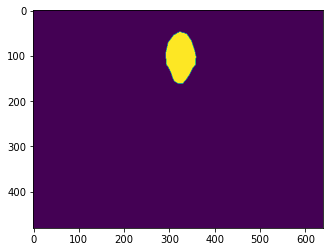

In [ ]:
import matplotlib.pyplot as plt

# plt.imshow(pred.detach().cpu().numpy()[..., 1])
plt.imshow(masks.cpu()[0, 1, ...])